In [ ]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import pandas as pd

import copulagp.marginal as mg
from copulagp import bvcopula
import torch
from scipy import interpolate

LENGTH = 200 #cm long VR corridor

def cond_interp(cond_u,u,rate,pos,bins=100,av=6):  
    '''
    Interpolates the inverse CCDF
    cond_u: conditioned variable from [0,1]
    u: a variable prior to conditioning [0,1]
    rate: a firing rate that corresponds to u
    pos: conditioning variable
    bins: number of bins
    av: number of neighbouring bins that are included
        in ccdf estimation (rule of thumb:
        make higher untill fix messages disappear)
    '''
    cond_y = np.empty_like(cond_u)
    for i in range(bins):
        mask_av = (pos>=(i-av)/bins) & (pos<=(i+av+1)/bins)
        mask = (pos>=i/bins) & (pos<=(i+1)/bins)
        if np.sum(mask)>0:
            if cond_u[mask].min()<u[mask_av].min():
                print('Fixing min')
                cond_u[mask & (cond_u<u[mask_av].min())] = u[mask_av].min()
            if cond_u[mask].max()>u[mask_av].max():
                print('Fixing max')
                cond_u[mask & (cond_u>u[mask_av].max())] = u[mask_av].max()
            interp = interpolate.interp1d(u[mask_av],rate[mask_av],
                                        kind='slinear')
            cond_y[mask] = interp(cond_u[mask])
        if np.any(cond_y==np.inf):
            print(cond_u[cond_y==np.inf],pos[cond_y==np.inf],u[mask].min(),rate[mask].min(),u[mask].max(),rate[mask].max())
    cond_y[rate<0.01] = rate[rate<0.01] # remove transformed jitter
    assert np.all(cond_y==cond_y)
    assert np.all(cond_y!=np.inf), cond_u[cond_y==np.inf]
    return cond_y

In [15]:
import glob

cohorts = glob.glob("Cohort*")
cohort = cohorts[0]
cohort

'Cohort7_october2020'

In [ ]:
device='cuda:0'
test_x = torch.linspace(0,1,100).float().to(device=device)

copulas_done = glob.glob(f"unconditional_copula/{cohort}/*.pkl")
copulas_done = [c.split('/')[-1].split('_copula')[0] for c in copulas_done]

print(copulas_done)

session_list = glob.glob(f"unconditional_uniform/{cohort}/*_u.pkl")
exceptions_count=0
for session in tqdm(session_list):
    save_name=(session.split('/')[-1]).split("_u.pkl")[0]
    
    if save_name in copulas_done:
        print(save_name," already done, skipping...")
    else:
        save_name = f"unconditional_copula/{cohort}/{save_name}_copula.pkl"
        data = pd.read_pickle(session)

        cond_y_vel_all, theta_vel_all, cond_y_acc_all, theta_acc_all = [], [], [], []
        for cluster_id in tqdm(range(len(data))):
            u_vel=data.iloc[cluster_id].u_vel
            u_acc=data.iloc[cluster_id].u_acc
            u_rate=data.iloc[cluster_id].u_rate
            [ds_rate, ds_vel, ds_pos, ds_acc, _, trial_type] = data.iloc[cluster_id].spikes_per50ms
            pos = ds_pos%LENGTH/LENGTH
            print(ds_rate.shape)

            train_x = torch.tensor(pos).float().to(device=device)
            train_y = torch.tensor(np.array([u_rate,u_vel]).T).float().to(device=device)

            likelihoods = [bvcopula.GaussianCopula_Likelihood()]
            %time (waic, model) = bvcopula.infer(likelihoods,train_x,train_y,\
                                                 device=device, prior_rbf_length=1.)
            print(f"WAIC: {waic}")

            model.gp_model.eval()
            with torch.no_grad():
                f = model.gp_model(train_x).mean
            copula = model.likelihood.get_copula(f) 
            try:
                cond_u = copula.ccdf(train_y).cpu().numpy()
            except:
                cond_u = copula.ccdf(train_y.clamp(0.001,0.999)).cpu().numpy()
                exceptions_count+=1
    #         print(cond_u.shape,u_rate.shape,ds_rate.shape)
            cond_y = cond_interp(cond_u,u_rate,ds_rate,pos,bins=50)

            theta = model.gplink(model.gp_model(test_x).mean)[0].squeeze().detach().cpu().numpy()

            cond_y_vel_all.append(cond_y)
            theta_vel_all.append(theta)

            train_y = torch.tensor(np.array([u_rate,u_acc]).T).float().to(device=device)

            likelihoods = [bvcopula.GaussianCopula_Likelihood()]
            %time (waic, model) = bvcopula.infer(likelihoods,train_x,train_y,\
                                                 device=device, prior_rbf_length=1.)
            print(f"WAIC: {waic}")

            model.gp_model.eval()
            with torch.no_grad():
                f = model.gp_model(train_x).mean
            copula = model.likelihood.get_copula(f)
            theta = model.gplink(model.gp_model(test_x).mean)[0].squeeze().detach().cpu().numpy()

            theta = copula.theta[0].cpu().numpy()
    #         print(np.min(theta), np.max(theta))
    #         print(np.min(train_y.cpu().numpy()),np.max(train_y.cpu().numpy()))
            try:
                cond_u = copula.ccdf(train_y).cpu().numpy()
            except:
                cond_u = copula.ccdf(train_y.clamp(0.001,0.999)).cpu().numpy()
                exceptions_count+=1
            cond_y = cond_interp(cond_u,u_rate,ds_rate,pos,bins=50)

            theta = model.gplink(model.gp_model(test_x).mean)[0].squeeze().detach().cpu().numpy()

            cond_y_acc_all.append(cond_y)
            theta_acc_all.append(theta)


        data['cond_y_vel']=cond_y_vel_all
        data['theta_vel']=theta_vel_all     
        data['cond_y_acc']=cond_y_acc_all
        data['theta_acc']=theta_acc_all
        data.to_pickle(save_name)
print('# exceptions: ',exceptions_count)

['M3_D23_2020-11-28_15-13-28_50ms', 'M3_D8_2020-11-07_14-39-22_50ms', 'M3_D21_2020-11-26_14-59-39_50ms', 'M6_D17_2020-11-20_15-40-03_50ms', 'M3_D29_2020-12-06_15-20-09_50ms', 'M3_D24_2020-11-29_15-08-39_50ms', 'M6_D23_2020-11-28_17-01-43_50ms', 'M3_D3_2020-10-31_14-05-19_50ms', 'M3_D5_2020-11-02_14-10-23_50ms', 'M4_D11_2020-11-12_15-03-41_50ms', 'M6_D14_2020-11-15_15-37-28_50ms', 'M3_D13_2020-11-14_14-25-12_50ms', 'M3_D19_2020-11-22_14-48-51_50ms', 'M3_D17_2020-11-20_14-23-44_50ms', 'M7_D6_2020-11-05_16-26-28_50ms', 'M7_D7_2020-11-06_16-14-44_50ms', 'M3_D6_2020-11-05_14-37-17_50ms', 'M3_D18_2020-11-21_14-29-49_50ms', 'M3_D7_2020-11-06_14-22-53_50ms', 'M6_D16_2020-11-19_14-30-17_50ms', 'M4_D8_2020-11-07_15-13-58_50ms', 'M6_D26_2020-12-03_16-42-12_50ms', 'M6_D3_2020-10-31_15-27-13_50ms', 'M7_D12_2020-11-13_16-20-54_50ms', 'M3_D11_2020-11-12_14-26-13_50ms', 'M7_D8_2020-11-07_16-24-43_50ms', 'M6_D12_2020-11-13_15-44-22_50ms', 'M3_D20_2020-11-23_14-32-20_50ms', 'M4_D22_2020-11-27_15-38-49_5

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

(36336,)
CPU times: user 21.3 s, sys: 204 ms, total: 21.5 s
Wall time: 15.4 s
WAIC: -0.04467054456472397
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
CPU times: user 21.4 s, sys: 136 ms, total: 21.5 s
Wall time: 15.5 s
WAIC: -0.007543361745774746
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
(36336,)
CPU times: user 31.7 s, sys: 212 ms, total: 31.9 s
Wall time: 25.9 s
WAIC: -0.021115271374583244
CPU times: user 21.5 s, sys: 252 ms, total: 21.8 s
Wall time: 15.7 s
WAIC: -0.016920270398259163
(36336,)
CPU times: user 21.6 s, sys: 204 ms, total: 21.8 s
Wall time: 15.7 s
WAIC: -0.01591230183839798
CPU times: user 21.7 s, sys: 180 ms, total: 21.8 s
Wall time: 15.8 s
WAIC: -0.009075528010725975
(36336,)
CPU times: user 21.6 s, sys: 220 ms, total: 21.8 s
Wall time: 15.7 s
WAIC: -0.08255091309547424
CPU times: user 21.6 s, sys: 208 ms

  0%|          | 0/6 [00:00<?, ?it/s]

(35862,)
CPU times: user 21.5 s, sys: 140 ms, total: 21.7 s
Wall time: 15.7 s
WAIC: -0.006811053957790136
CPU times: user 31.9 s, sys: 292 ms, total: 32.2 s
Wall time: 26.1 s
WAIC: -0.003200266743078828
(35862,)
CPU times: user 21.5 s, sys: 236 ms, total: 21.8 s
Wall time: 15.8 s
WAIC: -0.0024344483390450478
CPU times: user 21.5 s, sys: 212 ms, total: 21.7 s
Wall time: 15.7 s
WAIC: -0.00019796629203483462
(35862,)
CPU times: user 21.5 s, sys: 216 ms, total: 21.7 s
Wall time: 15.7 s
WAIC: -0.0012529166415333748
CPU times: user 21.6 s, sys: 168 ms, total: 21.8 s
Wall time: 15.7 s
WAIC: -0.001088082673959434
(35862,)
CPU times: user 21.6 s, sys: 196 ms, total: 21.8 s
Wall time: 15.7 s
WAIC: -0.0004308057250455022
CPU times: user 21.6 s, sys: 184 ms, total: 21.8 s
Wall time: 15.8 s
WAIC: -5.417486590886256e-06
(35862,)
CPU times: user 21.9 s, sys: 172 ms, total: 22 s
Wall time: 16 s
WAIC: -0.004462012089788914
CPU times: user 21.9 s, sys: 216 ms, total: 22.1 s
Wall time: 16 s
WAIC: -0.0001

  0%|          | 0/7 [00:00<?, ?it/s]

(35939,)
CPU times: user 26.5 s, sys: 248 ms, total: 26.8 s
Wall time: 20.7 s
WAIC: -0.028174549341201782
CPU times: user 21.5 s, sys: 184 ms, total: 21.7 s
Wall time: 15.6 s
WAIC: -0.009159966371953487
(35939,)
CPU times: user 16.6 s, sys: 215 ms, total: 16.8 s
Wall time: 10.7 s
WAIC: -0.0015180213376879692
CPU times: user 21.8 s, sys: 224 ms, total: 22 s
Wall time: 16 s
WAIC: -0.0008002519025467336
(35939,)
CPU times: user 21.4 s, sys: 189 ms, total: 21.6 s
Wall time: 15.6 s
WAIC: -0.0001816123112803325
CPU times: user 21.4 s, sys: 184 ms, total: 21.6 s
Wall time: 15.6 s
WAIC: -0.00010464494698680937
(35939,)
CPU times: user 21.5 s, sys: 184 ms, total: 21.7 s
Wall time: 15.6 s
WAIC: -0.0011642781319096684
CPU times: user 36.8 s, sys: 184 ms, total: 37 s
Wall time: 30.9 s
WAIC: -0.009077485650777817
(35939,)
CPU times: user 26.5 s, sys: 296 ms, total: 26.8 s
Wall time: 20.8 s
WAIC: -0.004437356721609831
CPU times: user 21.5 s, sys: 188 ms, total: 21.7 s
Wall time: 15.6 s
WAIC: -0.0008

  0%|          | 0/2 [00:00<?, ?it/s]

(35991,)
CPU times: user 37.7 s, sys: 212 ms, total: 37.9 s
Wall time: 31.9 s
WAIC: -0.006335367448627949
CPU times: user 22 s, sys: 220 ms, total: 22.2 s
Wall time: 16.1 s
WAIC: -0.023116130381822586
(35991,)
CPU times: user 22 s, sys: 200 ms, total: 22.2 s
Wall time: 16.1 s
WAIC: -0.15118873119354248
Fixing min
Fixing min
Fixing max
Fixing max
Fixing max
Fixing min
Fixing max
Fixing min
Fixing max
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
CPU times: user 22 s, sys: 184 ms, total: 22.2 s
Wall time: 16.1 s
WAIC: -0.01625974476337433
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
M3_D6_2020-11-05_14-37-17_50ms  already done, skipping...
M7_D19_2020-11-22_16-06-11_50ms  already done, skipping...
M3_D7_2020-11-06_14-22-53_50ms  already done, skipping...
M7_D8_2020-11-07_16-24-43_50ms  already done, skipping...
M3_D19_2020-11-22_14-48-51_50ms  alread

  0%|          | 0/7 [00:00<?, ?it/s]

(36174,)
CPU times: user 22.1 s, sys: 216 ms, total: 22.3 s
Wall time: 16.3 s
WAIC: -9.782240522326902e-05
CPU times: user 21.8 s, sys: 240 ms, total: 22.1 s
Wall time: 16 s
WAIC: -2.3383694497169927e-05
(36174,)
CPU times: user 21.9 s, sys: 184 ms, total: 22 s
Wall time: 16 s
WAIC: -0.001262384350411594
CPU times: user 21.8 s, sys: 200 ms, total: 22 s
Wall time: 15.9 s
WAIC: -0.0003016325645148754
(36174,)
CPU times: user 21.5 s, sys: 188 ms, total: 21.7 s
Wall time: 15.6 s
WAIC: -0.0245938953012228
Fixing max
Fixing min
Fixing min
CPU times: user 21.8 s, sys: 208 ms, total: 22 s
Wall time: 15.9 s
WAIC: -0.004514540545642376
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
(36174,)
CPU times: user 21.9 s, sys: 172 ms, total: 22.1 s
Wall time: 16 s
WAIC: -0.02625250816345215
CPU times: user 42.8 s, sys: 244 ms, total: 43 s
Wall time: 36.9 s
WAIC: -0.009330756030976772
(36174,)
CPU times: user 27 s, sys: 173 ms, total: 27.2 s
Wall time: 21.2 s
WAIC: -0.008041171357035637
CPU times

  0%|          | 0/15 [00:00<?, ?it/s]

(34553,)
CPU times: user 30.9 s, sys: 184 ms, total: 31.1 s
Wall time: 25 s
WAIC: -0.026534080505371094
CPU times: user 20.9 s, sys: 212 ms, total: 21.1 s
Wall time: 15.2 s
WAIC: -0.01905851997435093
(34553,)
CPU times: user 26 s, sys: 180 ms, total: 26.1 s
Wall time: 20.1 s
WAIC: -0.02327888272702694
CPU times: user 21 s, sys: 188 ms, total: 21.2 s
Wall time: 15.1 s
WAIC: -0.016803573817014694
(34553,)
CPU times: user 30.9 s, sys: 228 ms, total: 31.2 s
Wall time: 25.1 s
WAIC: -0.010936377570033073
Fixing max
Fixing max
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing min
Fixing max
Fixing min
Fixing min
Fixing min
CPU times: user 25.9 s, sys: 249 ms, total: 26.2 s
Wall time: 20.1 s
WAIC: -0.00038084364496171474
Fixing min
Fixing min
(34553,)
CPU times: user 35.9 s, sys: 252 ms, total: 36.1 s
Wall time: 30 s
WAIC: -0.08475393056869507
Fixing min
CPU times: user 21 s, sys: 164 ms, total: 21.2 s
Wall time: 15.1 s
WAIC: -0.03106476552784443
(3

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Text(0.5, 1.0, 'M6_D6_2020-11-05_15-50-22, #14')

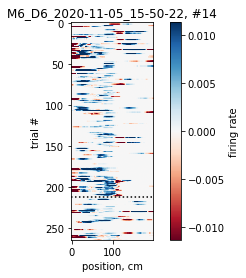

In [43]:
cluster_id=4
[ds_rate, ds_vel, ds_pos, trial_num, trial_type] = data.iloc[cluster_id].spikes_per50ms
pos_t0 = ds_pos[trial_type==0]/LENGTH
pos_t1 = ds_pos[trial_type==1]/LENGTH
ds_rate_t0 = ds_rate[trial_type==0]
ds_rate_t1 = ds_rate[trial_type==1]
trial_num_t0 = trial_num[trial_type==0]
trial_num_t1 = trial_num[trial_type==1]
cond_y_t0 = data.iloc[cluster_id].cond_y_t0
cond_y_t1 = data.iloc[cluster_id].cond_y_t1

n_bins=100

def both_types_in_pos_bins(trial,pos,rate):
    A_t0 = np.zeros((len(np.unique(trial_num_t0)),n_bins))
    A_t1 = np.zeros((len(np.unique(trial_num_t1)),n_bins))
    for A_tx, trial_num_tx, pos_tx, u_rate_tx in zip([A_t0,A_t1],
                                             trial,pos,rate):

        for j,trial in tqdm(enumerate(np.unique(trial_num_tx))):
            pos = pos_tx[trial_num_tx==trial]
            for i in range(n_bins):
                mask = (pos>=(i-m)/n_bins) & (pos <=(i+1+m)/n_bins)
                if np.sum(mask)!=0:
                    A_tx[j,i] = u_rate_tx[trial_num_tx==trial][mask].mean()

    return np.concatenate([A_t0,A_t1])
A=both_types_in_pos_bins([trial_num_t0,trial_num_t1],[pos_t0, pos_t1],[ds_rate_t0,ds_rate_t1])
B=both_types_in_pos_bins([trial_num_t0,trial_num_t1],[pos_t0, pos_t1],[cond_y_t0,cond_y_t1])

Hz_range = np.mean(A,axis=0).max(0)*1.2 # mean FR at the location with the highest FR
#     print(A.shape)
plt.imshow(B,vmin=0,vmax=Hz_range)
Hz_range = np.mean(A,axis=0).max(0)*0.5
plt.imshow(A-B,vmin=-Hz_range,vmax=Hz_range,cmap="RdBu")
plt.axhline(len(np.unique(trial_num_t0)),color='k',linestyle=':')
plt.xticks([0,50],[0,100])
plt.colorbar(label='firing rate')
plt.xlabel('position, cm')
plt.ylabel('trial #')
plt.title(f'{data.iloc[cluster_id].session_id}, #{data.iloc[cluster_id].cluster_id}')
# fig.colorbar(plot);

In [31]:
diff_before_after=np.zeros((len(data),2))
for cluster_id in range(len(data)):
    [ds_rate, ds_vel, ds_pos, trial_num, trial_type] = data.iloc[cluster_id].spikes_per50ms
    pos_t0 = ds_pos[trial_type==0]#/LENGTH
    pos_t1 = ds_pos[trial_type==1]#/LENGTH
    ds_rate_t0 = ds_rate[trial_type==0]
    ds_rate_t1 = ds_rate[trial_type==1]
    cond_y_t0 = data.iloc[cluster_id].cond_y_t0
    cond_y_t1 = data.iloc[cluster_id].cond_y_t1

    diff_before_after[cluster_id] = (np.mean(np.abs(ds_rate_t0[pos_t0<90]-cond_y_t0[pos_t0<90])),np.mean(np.abs(ds_rate_t0[pos_t0>110]-cond_y_t0[pos_t0>110])))

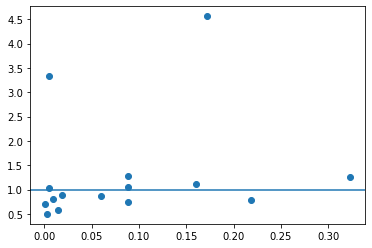

In [38]:
plt.scatter(diff_before_after[:,0],diff_before_after[:,0]/diff_before_after[:,1])
plt.axhline(1)

In [39]:
diff_before_after[:,0]/diff_before_after[:,1]

array([1.2813711 , 1.06381113, 0.86413958, 4.56006942, 3.33954371,
       0.50112007, 1.0383677 , 0.81396588, 0.88077493, 0.58142298,
       0.73871457, 0.70635461, 1.25864089, 0.79434516, 1.1124482 ])

In [41]:
diff_before_after[:,0]

array([0.08829536, 0.08879243, 0.05972038, 0.17232848, 0.00510171,
       0.00297361, 0.00539347, 0.00930441, 0.01899043, 0.01430119,
       0.08834278, 0.00124203, 0.32272563, 0.2186179 , 0.16065523])